<h1><center>Analytathon-3</center></h1>
<h2><center>Energeia Group - Analysis, Forecasting and Strategy Development</center></h2>

# 1. Abstract
This report aims to represents the taks as follows
- PART 1: Identify the factors resulted in the rise of the I-SEM Day Ahead Price for month July 2021
- PART 2: Develop different Trade stratergies for maximum profit revenue

In [200]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [201]:
combined_data_o=pd.read_excel("./part1.xlsx",sheet_name=0,parse_dates=True)
commodity_price_o=pd.read_excel("./part1.xlsx","Commodity Prices",parse_dates=True)
net_demand_o= pd.read_excel("./part1.xlsx","Net Demand Data")
keygen_avail_o= pd.read_excel("./part1.xlsx","Key Generator Availability")
keygen_cost_o= pd.read_excel("./part1.xlsx","Key Generator Costs")

In [202]:
# Creating a copy of data
combined_data = combined_data_o
commodity_price = commodity_price_o
net_demand = net_demand_o
keygen_avail = keygen_avail_o
keygen_cost = keygen_cost_o

In [203]:
## Data preprocessing for DAM hourly and monthly

combined_data = combined_data.iloc[2:,]
dam_hourly = combined_data.iloc[:,0:6]
dam_monthly= combined_data.iloc[:,8:10]
dam_hourly = dam_hourly.rename(columns={"Unnamed: 0": "start_time", 
                           "Unnamed: 1": "month", 
                           "Unnamed: 2": "year",
                           "Unnamed: 3": "trade_date",
                           "Unnamed: 4": "start_date",
                           "Unnamed: 5": "DAM_price"}).reset_index(drop=True)


dam_monthly = dam_monthly.rename(columns={"Unnamed: 8": "trade_month", 
                            "Unnamed: 9": "DAM_price"}).reset_index(drop=True)


## Data preprocessing for commodity_price
commodity_price = commodity_price.iloc[2:,]
commodity_price = commodity_price.rename(columns={"Unnamed: 0": "date", 
                           "Unnamed: 1": "gas",
                           "Unnamed: 2": "carbon",
                           "Unnamed: 3": "coal",
                           "Unnamed: 4": "oil",
                           "Unnamed: 5": "Distillate",
                           "Unnamed: 6": "Exchange_rate"}).reset_index(drop=True)

## Data preprocessing for net_demand
net_demand = net_demand.iloc[2:,]
net_demand = net_demand.rename(columns={"Unnamed: 0": "date", 
                           "Unnamed: 1": "day_wind",
                           "Unnamed: 2": "cont_wind",
                           "Unnamed: 3": "actual_wind",
                           "Unnamed: 4": "day_demand",
                           "Unnamed: 5": "cont_demand",
                           "Unnamed: 6": "actual_demand",
                           "Unnamed: 7": "day_netdemand",
                           "Unnamed: 8": "cont_netdemand",
                           "Unnamed: 9": "actual_netdemand"}).reset_index(drop=True)


## Data preprocessing for keygen_avail
fuel_info = keygen_avail.iloc[1:3,2:].T.reset_index(drop=True).rename(columns={1: "fuel",2:"Generator"})
fuel_info.head()
keygen_avail.columns = keygen_avail.iloc[2]
keygen_avail=keygen_avail.iloc[3:].reset_index(drop=True)
keygen_avail = keygen_avail.rename(columns={"2": " ", 
                           "Start Date": "date",
                           "Start Time 30 Minute Period": "time"})


## Data preprocessing for keygen_cost
keygen_cost.columns = keygen_cost.iloc[2]
keygen_cost = keygen_cost[3:].reset_index(drop=True)
keygen_cost = keygen_cost.rename(columns={"Daily Av €/MWh cost": "Daily_avg_cost"})



dam_monthly = dam_monthly.infer_objects()
dam_hourly = dam_hourly.infer_objects() 
commodity_price = commodity_price.infer_objects()
net_demand = net_demand.infer_objects()
fuel_info = fuel_info.infer_objects()
keygen_avail = keygen_avail.infer_objects()
keygen_cost = keygen_cost.infer_objects()

dam_monthly['trade_month'] = pd.to_datetime(dam_monthly['trade_month'])
commodity_price['date'] = pd.to_datetime(commodity_price['date'])

# 2. PART 1: Data Preprocessing

The Data is provided in an excel sheets and is spread accross different sheets. The data is imported sucessfully and below is quick glimpse on the dimension of all the data to be used for further Analysis

In [204]:
## Veryfying the data

data_list =[dam_monthly,dam_hourly,commodity_price,net_demand,fuel_info,keygen_avail,keygen_cost]
data_names =["Monthy DAM","Hourly DAM","Commodity Prices","Net Demand","Generator Fuel","Key generator Availaibility","Key generator Cost"]
for i,data in enumerate(data_list):
    print(f"{data_names[i]} :: {data_list[i].shape}") 

Monthy DAM :: (24790, 2)
Hourly DAM :: (24790, 6)
Commodity Prices :: (1004, 7)
Net Demand :: (49392, 10)
Generator Fuel :: (18, 2)
Key generator Availaibility :: (48138, 20)
Key generator Cost :: (18558, 24)


The main motive of part 1 is to identify the reason for increase in DAM price for July 2021, To understand this lets get an overview of price trends accross years for varisous commodities. Currently in market there is a high demand for Coal and Gas, used fuel to generate electricity. To Our surprise we see there us a spiked seen in year 2021 with the highest price recorded for both on June 30 2021.

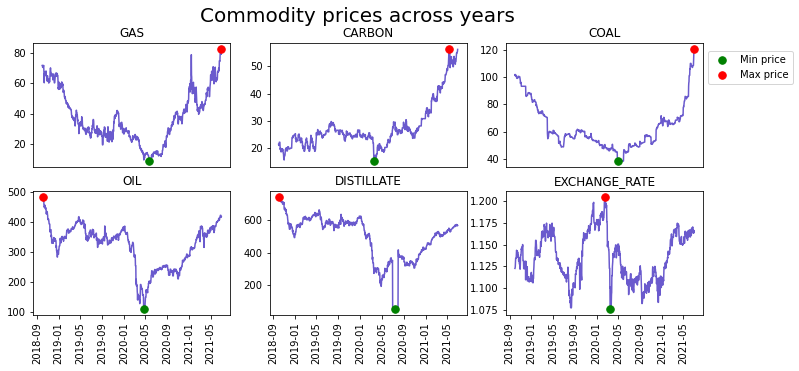

In [205]:
# Plot for Commodity prices accross years

plt.figure(figsize=(12,5))
plot=231
for i in range(1,7):
    plt.subplot(plot)
    min_date = commodity_price.iloc[np.argmin(commodity_price.iloc[:,i]),0]
    max_date = commodity_price.iloc[np.argmax(commodity_price.iloc[:,i]),0]
    plt.plot(commodity_price.iloc[:,0],commodity_price.iloc[:,i], color="slateblue")
    plt.plot(min_date,min(commodity_price.iloc[:,i]),"g.",markersize=15, label="Min price")
    plt.plot(max_date,max(commodity_price.iloc[:,i]),"r.",markersize=15, label="Max price")
    if (plot <234):
        plt.xticks([])
    plt.xticks(rotation=90)
    plt.title(str.upper(commodity_price.columns[i]))
    plot=plot+1
plt.suptitle("Commodity prices across years", fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 2))

To get a better understand on the relationship between the commodity prices and DAM prices a correaltion plot is created. There is a good positive correlation between coal vs DAM and Gas vs DAM, which means increase in Coal or Gas price will defintiely increase the DAM price. Other commodities like oil and distillate has a moderate correlation but there is no recent increase seen in them and hence may not be the factors driving recent price change.

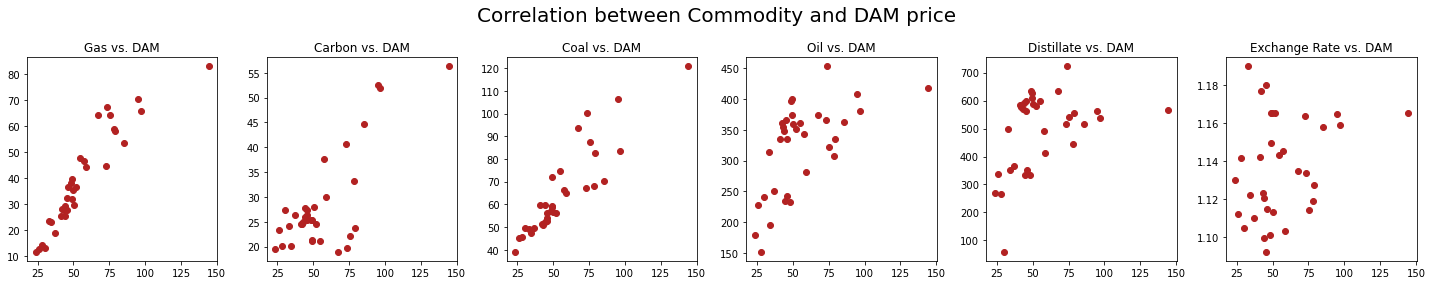

In [206]:
# Veirfy the correlation between the variables
corr1 =commodity_price.resample('1M', on='date',label="left", closed="left").mean().reset_index(drop=True)
corr2 =dam_monthly[dam_monthly["trade_month"] <= "2021-07-01"]['DAM_price'].reset_index(drop=True)
final_cor = pd.concat([corr1, corr2], axis=1, ignore_index=True)
final_cor.columns=["Gas","Carbon","Coal","Oil","Distillate","Exchange Rate","DAM_price"]

plt.figure(figsize=(20,4))
plot=161
for i in range(0,6):
    plt.subplot(plot)
    plt.scatter(final_cor.iloc[:,6],final_cor.iloc[:,i],color="firebrick")
    plt.title(f"{final_cor.columns[i]} vs. DAM")
    plot=plot+1
plt.suptitle("Correlation between Commodity and DAM price", fontsize=20)
plt.tight_layout()

Next focus was to gain some insight on the wind data and see if there are any seasonal patterns occuring. The below plots is created to study hourly and seasonal patterns and below are some of the observations

**Hourly:** There are weak winds during midnight and strong winds observed during day time after 12PM

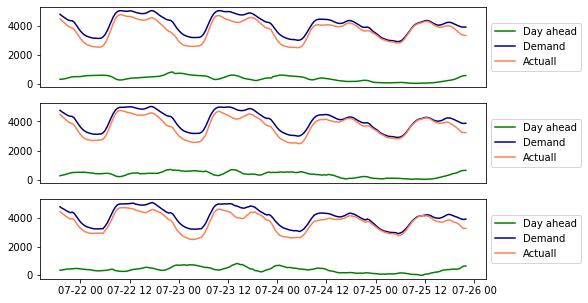

In [207]:
plt.figure(figsize=(8,5))
plot=311
new = net_demand.iloc[-200:-1]
for i in range (1,4):
    plt.subplot(plot)
    if (plot < 313):
        plt.xticks([])
    plt.plot(new.iloc[:,0],new.iloc[:,i+0],color="g",label="Day ahead")
    plt.plot(new.iloc[:,0],new.iloc[:,i+3],color="navy",label="Demand")
    plt.plot(new.iloc[:,0],new.iloc[:,i+6],color="coral",label="Actuall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plot=plot+1

**Seasonal:** We do there are patterns occuring in second plot where the wind is stronger mostly during the winter seasons and wind strength drops during summer, as July and June are the mid of summer months and hence Electricity Generators cannot depends much on wind for electricity generation and look for other commodities.

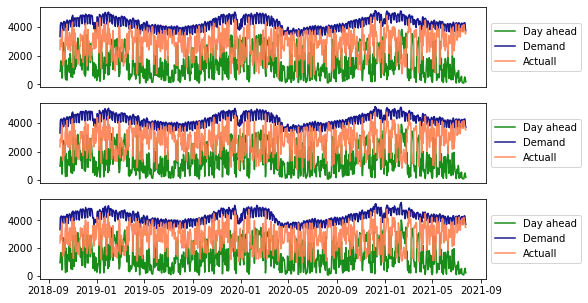

In [208]:
plt.figure(figsize=(8,5))
plot=311
new= net_demand.resample('1d', on='date',label="left", closed="left").mean()
for i in range (0,3):
    plt.subplot(plot)
    if (plot < 313):
        plt.xticks([])
    plt.plot(new.index,new.iloc[:,i+0],color="g",alpha=0.9,label="Day ahead")
    plt.plot(new.index,new.iloc[:,i+3],color="navy",alpha=0.9,label="Demand")
    plt.plot(new.index,new.iloc[:,i+6],color="coral",alpha=0.9,label="Actuall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plot=plot+1

The below table shows that the majority of Generators use Gas as there fuel to produce electricity

In [209]:
d1=pd.DataFrame(fuel_info.groupby("fuel").count())
d1

,Generator
fuel,
Coal,5
Gas,13


Generators producing electricity based on the fuel used are as below

In [210]:
gen_coal_list = d2[d2["fuel"] == "Coal"]["Generator"].tolist()
gen_gas_list = d2[d2["fuel"] == "Gas"]["Generator"].tolist()
print(f"Coal Generators:: {gen_coal_list}")
print(f"Gas Generators:: {gen_gas_list}")

KeyError: 'fuel'

Here we are with the most important factor "Key Generators". The plots clearly shows that some of the Key generators are down during the month of July either due to maintainance or producing less units of electricity. This made the other active generating units to increase the price by a margin of 5% - 10% from June to July.

In [ ]:
keygen_avail['date'] = pd.to_datetime(keygen_avail['date'])
coal_gem = fuel_info[fuel_info["fuel"] =="Coal"][['Generator']]
gas_gem = fuel_info[fuel_info["fuel"] =="Gas"][['Generator']]
keygen_avail_month= keygen_avail.resample('6m',on='date',label="left", closed="left").mean()

coal_data_roi = keygen_avail_month[coal_gem["Generator"].reset_index(drop=True)[0:3]]
coal_data_ni = keygen_avail_month[coal_gem["Generator"].reset_index(drop=True)[3:5]]
gas_data_roi = keygen_avail_month[gas_gem["Generator"].reset_index(drop=True)[0:9]]
gas_data_ni = keygen_avail_month[gas_gem["Generator"].reset_index(drop=True)[9:16]]


plt.figure(figsize=(25,12))
plt.subplot(221)
data_c_roi = coal_data_roi[-25:].fillna(0)
for i in range(0,len(coal_data_roi.columns)):
    plt.plot(data_c_roi.index,data_c_roi.iloc[:,i], label=data_c_roi.columns[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Key Generator - Coal with ROI Units",fontsize=20)
    
plt.subplot(222)
data_c_ni = coal_data_ni[-25:].fillna(0)
for i in range(0,len(coal_data_ni.columns)):
    plt.plot(data_c_ni.index,data_c_ni.iloc[:,i], label=data_c_ni.columns[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Key Generator - Coal with NI Units",fontsize=20)

plt.subplot(223)
data_g_roi = gas_data_roi[-25:].fillna(0)
for i in range(0,len(data_g_roi.columns)):
    plt.plot(data_g_roi.index,data_g_roi.iloc[:,i], label=data_g_roi.columns[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Key Generator - Gas with ROI Units",fontsize=20)

plt.subplot(224)
data_g_ni = gas_data_ni[-25:].fillna(0)
for i in range(0,len(gas_data_ni.columns)):
    plt.plot(data_g_ni.index,data_g_ni.iloc[:,i], label=data_g_ni.columns[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Key Generator - Gas with NI Units",fontsize=20)

In [ ]:
gene_drop = ["GU_400270","GU_400271","GU_400272","GU_500822","GU_500823","GU_400500","GU_400540","GU_400930"]
keygen_cost['Start Date'] = pd.to_datetime(keygen_cost['Start Date']).fillna(0)
dropping_keygen = keygen_cost[keygen_cost['Resource Code'].isin(gene_drop)].fillna(0)

In [ ]:
gen = ["GU_400530","GU_400850","GU_400480","GU_400530","GU_400324","GU_400325","GU_400270","GU_500040","GU_500130"]
price_list = []

for i in gen:
    data = keygen_cost[keygen_cost["Resource Code"] == i]
    data = data.fillna(0)
    june_price = round(data [(data["Start Date"] >= "2021-06-01") & (data["Start Date"] <= "2021-06-30")]["Daily_avg_cost"].mean(),2)
    july_price = round(data [(data["Start Date"] >= "2021-07-01") & (data["Start Date"] <= "2021-07-31")]["Daily_avg_cost"].mean(),2)
    price_list.append([june_price,july_price])
    
price_df = pd.DataFrame (price_list,columns=['June Price', "July Price"])
price_df

# 3. PART 1: Machine Learning model (Vector autoregression)

To understand the increase in price rise to need to find the future values of Coal and Gas and use these new prices to forecase the DAM prices. A Vector autoregression is used along with a lag of 3.

Below plot is quicK look on how exactly the Coal, Gas and DAM relate. Each of the series have a fairly similar trend patterns over the years 

In [ ]:
data1 =commodity_price.resample('1M', on='date',label="left", closed="left").mean().reset_index(drop=True)
data2 =dam_monthly[dam_monthly["trade_month"] <= "2021-07-01"].reset_index(drop=True)
data3 = dam_monthly[dam_monthly["trade_month"] > "2021-07-01"].reset_index(drop=True)
final_data= pd.concat([data1, data2], axis=1, ignore_index=True)
final_data.columns=["Gas","Carbon","Coal","Oil","Distillate","Exchange Rate","date","DAM_price"]
# Preparing the data, we need the index to have datetime
final_data['date'] = pd.to_datetime(final_data.date , format = '%d/%m/%Y')
new_data = final_data.drop(['date'], axis=1)
new_data.index = final_data.date
new_data = new_data[["Gas","Coal","DAM_price"]]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=120, figsize=(20,4))
for i, ax in enumerate(axes.flatten()):
    data = new_data[new_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(new_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

**Testing Causation using Granger’s Causality Test**
Looking at the P-Values in the below table, we can pretty much observe that all the variables (time series) in the system are interchangeably causing each other.

In [ ]:

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=3
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(new_data, variables = new_data.columns) 

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series and below are the details

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(new_data)

In [ ]:
# Creating train and test data

nobs = 4
df_train, df_test = new_data[0:-nobs], new_data[-nobs:]

Check for Stationarity and Make the Time Series Stationary. ADF Test. Augmented Dickey-Fuller Test (ADF Test)

In [ ]:

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

**ADF test confirms none of the time series is stationary. Let’s difference all of them once and check again.**

In [ ]:

df_differenced = df_train.diff().diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')
    

In [ ]:
model = VAR(df_differenced)

**Training the model with LAG 4 of selected order**

In [ ]:
model_fitted = model.fit(4)
model_fitted.summary()

In [ ]:
# Forecast VAR model using statsmodels
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]

In [ ]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=new_data.index[-nobs:], columns=new_data.columns + '_2d')


In [ ]:
# Invert the transformation to get the real forecast
def invert_transformation(df_train, df_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:    
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_train, df_forecast, second_diff=True)

The data is forecasted with Vector Autoregression model and below is the forecast for the test data

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=150, figsize=(10,3))
for i, (col,ax) in enumerate(zip(new_data.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

A Quick glimpse on forecast values for future 8 months

In [ ]:
future_c = model_fitted.forecast(y=forecast_input,steps=8)
future_forecast = pd.DataFrame(future_c,index=data3.trade_month, columns=new_data.columns + '_2d')


df_future_results = invert_transformation(df_train, future_forecast, second_diff=True)

df_future_results[["Gas_forecast","Coal_forecast","DAM_price_forecast"]]


# 4. PART 2: Conclusion

By taking all the factors into consideration, the future prices were predictd and there new prices were uwed to forecast the DAM data. 
These Observation bring us to a conclusion that Coal, gas and key generator price resulted in a increase of DAM price and as per the forecast the prices will reduce in the next comming months and again spiked back in March 2022, which is something to be worried about.

In [ ]:
d2 =df_future_results.loc[:, ['Gas_forecast', 'Coal_forecast', 'DAM_price_forecast']]
d2.index.names = ['date']
d2.columns=["Gas","Coal","DAM_price"]
last_data= pd.concat([new_data, d2], axis=0, ignore_index=False)

plt.figure(figsize=(15,3))
plt.plot(last_data.index, last_data['DAM_price'],label="Historical")
plt.plot(last_data.index[-9:], last_data['DAM_price'][-9:],"r",label="Forecast")
plt.axvspan(last_data.index[-9], last_data.index[-1],color='gray', alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("DAM Price (€/MWh)")
plt.title ("Monthly I-SEM Day Ahead Price Forecast\n", fontsize=17)
plt.grid(axis = 'y',linestyle = '--', linewidth = 0.7,alpha=0.4)
plt.grid(axis = 'x',linestyle = '--', linewidth = 0.7,alpha=0.4)

plt.figure(figsize=(15,3))
plt.bar(last_data.index, last_data['DAM_price'],label="Historical",width=20)
plt.bar(last_data.index[-9:], last_data['DAM_price'][-9:],width=20,color="red",label="Forecast")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("DAM Price (€/MWh)")
plt.title ("Evolution of the I-SEM Day Ahead Price and Forecast\n", fontsize=17)
xtick_location = pd.to_datetime(last_data.index).tolist()[::1]
xtick_labels =pd.to_datetime(last_data.index).tolist()[::1]
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=90, alpha=.7)
plt.grid(axis = 'y',linestyle = '--', linewidth = 0.7,alpha=0.4)
plt.grid(axis = 'x',linestyle = '--', linewidth = 0.7,alpha=0.4)

# 5. PART 2: Data Preprocessing

The Data is provided in an excel sheets and is spread accross different sheets. The data provided has information about the variuous prices seen in ISEM markets based on theere auction trade prices (DAM,IDA1,IDA2,IDA3,BM). The data is divided into 3 years 2019,2020,2021.

The data types are changes for all features and any NA's are converted to 0

In [ ]:
isem_2021_o=pd.read_excel("./part2.xlsx",sheet_name="2021",parse_dates=True)
isem_2020_o=pd.read_excel("./part2.xlsx",sheet_name="2020",parse_dates=True)
isem_2019_o=pd.read_excel("./part2.xlsx",sheet_name="2019",parse_dates=True)

In [ ]:
isem_2021 = isem_2021_o
isem_2020 = isem_2020_o
isem_2019 = isem_2019_o

In [ ]:
def create_isem_df(data):
    isem_data = data
    isem_data.columns = isem_data.iloc[1]
    isem_data = isem_data.iloc[2:]
    isem_data = isem_data.iloc[:,1:21].reset_index(drop=True)
    isem_prices = isem_data.iloc[:,[1,3,4,5,6,7,10]].reset_index(drop=True).fillna(0)
    isem_demand = isem_data.iloc[:,11:].reset_index(drop=True).fillna(0)
    isem_prices_col = ["trade_date","DAM","IDA1","IDA2","IDA3","BM","Cal_date"]
    isem_demand_col = ["Day_Wind","Cont_Wind","Output_Wind",
                       "Day_Demand","Cont_Demand","Output_Demand",
                       "Day_NetDemand","Cont_NetDemand","Output_NetDemand"]
    isem_prices.columns=isem_prices_col
    isem_demand.columns=isem_demand_col

    cols = list(isem_prices.columns)
    cols = [cols[-1]] + cols[:-1]
    isem_prices = isem_prices[cols]
    isem_prices

    isem_prices = isem_prices.infer_objects()
    isem_demand = isem_demand.infer_objects()
    isem_prices['trade_date'] = pd.to_datetime(isem_prices['trade_date'], format = '%d/%m/%Y')

    isem_complete= pd.concat([isem_prices, isem_demand], axis=1, ignore_index=False)
    return (isem_complete)

def check_for_na(data,year):
    na_info = data.isna().values.any()
    if na_info:
        print(f"NA found in year {year}")
    else:
        print(f"No NA found in year {year}")
        

In [ ]:
isem_complete_2019 = create_isem_df(isem_2019)
isem_complete_2020 = create_isem_df(isem_2020)
isem_complete_2021 = create_isem_df(isem_2021)

Verify if there is any NA data in the complete data frame

In [ ]:
check_for_na(isem_complete_2019,"2019")
check_for_na(isem_complete_2020,"2020")
check_for_na(isem_complete_2021,"2021")

In [ ]:
def plot_isemprices(data,title):
    plt.figure(figsize=(10,2))
    plt.plot(data.Cal_date,data.DAM,label="DAM")
    plt.plot(data.Cal_date,data.IDA1,label="IDA1")
    plt.plot(data.Cal_date,data.IDA2,label="IDA2")
    plt.plot(data.Cal_date,data.IDA3,label="IDA3")
    plt.plot(data.Cal_date,data.BM,"--",color="grey",label="BM")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title,fontsize=17)
    plt.grid()
        
def plot_windforecast(data):
    plt.figure(figsize=(10,2))
    plt.plot(data.Cal_date,data.Day_Wind,label="Day_Wind",color="silver")
    plt.plot(data.Cal_date,data.Cont_Wind,"--",label="Cont_Wind",color="black")
    plt.plot(data.Cal_date,data.Output_Wind,label="Output_Wind", color="black")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
def plot_netdemandforecast(data):
    plt.figure(figsize=(10,2))
    plt.plot(data.Cal_date,data.Day_NetDemand,label="Day_NetDemand",color="darkred")
    plt.plot(data.Cal_date,data.Cont_NetDemand,"--",label="Cont_NetDemand",color="darkred")
    plt.plot(data.Cal_date,data.Output_NetDemand,label="Output_NetDemand", color="salmon")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
def plot_data_compare(data,title):
    plot_isemprices(data,title)
    plot_windforecast(data)
    plot_netdemandforecast(data)

In [ ]:
### Trade 1 - Market 1
def trade_mark1(row):
    if ((row["IDA2"] == 0) &
        (row["IDA3"] == 0) &
        (row['Output_Wind'] <= 1000) &
        (row['Day_NetDemand'] > 1200)):
        return (row["BM"] - row["DAM"])
    else:
        return (0)

### Trade 1 - Market 2
def trade_mark2(row):
    if ((row["IDA2"] > 0) &
        (row["IDA3"] == 0) &
        (row['Output_Wind'] <= 1000) &
        (row['Day_NetDemand'] > 1200)):
        return (row["BM"] - row["IDA1"])
    else:
        return (row["PL"])
    
### Trade 1 - Market 3
def trade_mark3(row):
    if ((row["IDA2"] > 0) &
        (row["IDA3"] > 0) &
        (row['Output_Wind'] <= 1000) &
        (row['Day_NetDemand'] > 1200)):
        return (row["DAM"] - row["IDA3"])
    else:
        return (row["PL"])

def prepare_market(data,year):
    print("-------------------------------")
    print(f"Details of year {year}")
    print("-------------------------------")
    market_1 = data[(data["IDA2"] == 0) &
                         (data["IDA3"] == 0)]
    market_2 = data[(data["IDA2"] > 0) &
                             (data["IDA3"] == 0)]
    market_3 = data[(data["IDA2"] > 0) &
                             (data["IDA3"] > 0)]
    Trade = data
    Trade['PL'] = Trade.apply(lambda row : trade_mark1(row), axis = 1)
    print(f"Market 1 with win trades {Trade[Trade['PL'] >0].shape[0]} and max profit is {round(max(Trade['PL']),2)}")
    print(f"Market 1 with Loss trades {Trade[Trade['PL'] <0].shape[0]} and min profit is {round(min(Trade['PL']),2)}")
    Trade['PL'] = Trade.apply(lambda row : trade_mark2(row), axis = 1)
    print(f"Market 2 with win trades {Trade[Trade['PL'] >0].shape[0]} and max profit is {round(max(Trade['PL']),2)}")
    print(f"Market 2 with Loss trades {Trade[Trade['PL'] <0].shape[0]} and min profit is {round(min(Trade['PL']),2)}")
    Trade['PL'] = Trade.apply(lambda row : trade_mark3(row), axis = 1)
    print(f"Market 3 with win trades {Trade[Trade['PL'] >0].shape[0]} and max profit is {round(max(Trade['PL']),2)}")
    print(f"Market 3 with Loss trades {Trade[Trade['PL'] <0].shape[0]} and min profit is {round(min(Trade['PL']),2)}")
    return (Trade,market_1,market_2,market_3)

For the data given for 2021 patterns were captured between the different trade markt prices and pther factors like wind and net demand. The trends were captured for Yearly, houry, Weekend, Monthly and seasonal. Below is a snippet taken from a week report and split acrros 3 markets to understand the prices variations.

In [ ]:
M1_2021_inspect = M1_2021[(M1_2021['Cal_date'] >="2021-03-01 00:23:00.000") &
                (M1_2021['Cal_date'] <"2021-03-08 00:23:00.000")]

M2_2021_inspect = M2_2021[(M2_2021['Cal_date'] >="2021-03-01 00:23:00.000") &
                (M2_2021['Cal_date'] <"2021-03-08 00:23:00.000")]

M3_2021_inspect = M3_2021[(M3_2021['Cal_date'] >="2021-03-01 00:23:00.000") &
                (M3_2021['Cal_date'] <"2021-03-08 00:23:00.000")]

plot_data_compare(M1_2021_inspect,"Market 1 with DAM,ID1,BM")
plot_data_compare(M2_2021_inspect,"Market 2 with DAM,ID1,ID2,BM")
plot_data_compare(M3_2021_inspect,"Market 3 with DAM,ID1,ID2,ID3,BM")

From the trends and patterns examined, there are 3 trading stratergies finalised each for every trade market. There are 2 short trades and 1 long trade. The below are stratergies by keeping the wind and net demand patterns keeping same accross all the auction trades.

**Trade in Market 1:**
Buy in DAM and Sell in BM when Output Wind < 1200 and Day net demand is > 1200 

**Trade in Market 2**
Buy in IDA1 and Sell in BM when Output Wind < 1200 and Day net demand is > 1200 

**Trade in Market 3**
Sell in IDA3 and Buy in DAM when Output Wind < 1200 and Day net demand is > 1200 

The win and loss trades numbers and along with there profit and lose values are given below.

In [ ]:
Trade_2019,M1_2019,M2_2019,M3_2019 = prepare_market(isem_complete_2019,"2019")
Trade_2020,M1_2020,M2_2020,M3_2020 = prepare_market(isem_complete_2020,"2020")
Trade_2021,M1_2021,M2_2021,M3_2021 = prepare_market(isem_complete_2021, "2021")

pl_data_2019 = pd.DataFrame([np.arange(0,Trade_2019['PL'].shape[0]), Trade_2019['PL'], np.cumsum(Trade_2019['PL'])]).T
pl_data_2019.columns=["Iter","PL","PL_cum"]

pl_data_2020 = pd.DataFrame([np.arange(0,Trade_2020['PL'].shape[0]), Trade_2020['PL'], np.cumsum(Trade_2020['PL'])]).T
pl_data_2020.columns=["Iter","PL","PL_cum"]

pl_data_2021 = pd.DataFrame([np.arange(0,Trade_2021['PL'].shape[0]), Trade_2021['PL'], np.cumsum(Trade_2021['PL'])]).T
pl_data_2021.columns=["Iter","PL","PL_cum"]

The graph below shows a Drmatic increase in the DAM values for every 1MWatt

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(pl_data_2021.Iter, pl_data_2021.PL_cum,label="2021",color="green")
plt.plot(pl_data_2021['Iter'].iloc[-1], pl_data_2021['PL_cum'].iloc[-1],"r.",markersize=15)
plt.text(pl_data_2021['Iter'].iloc[-1]-200, pl_data_2021['PL_cum'].iloc[-1]-3000,f"{round(pl_data_2021['PL_cum'].iloc[-1])}")
plt.xlim(0,pl_data_2021.shape[0]+500)
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)
plt.ylabel('€/MWh',fontsize=15,alpha=.6)
xtick_location = pl_data_2021.Iter.tolist()[::500]
xtick_labels = pl_data_2021.Iter.tolist()[::500]
ytick_location = np.arange(-6000,35000,3000)
ytick_labels = np.arange(-6000,35000,3000)
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=90, alpha=.7)
plt.yticks(ticks=ytick_location, labels=ytick_labels,alpha=.7)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Cum. Profit and Loss for year 2021\n", fontsize=22)
plt.grid(axis = 'y',linestyle = '--', linewidth = 0.7)
plt.grid(axis = 'x',linestyle = '--', linewidth = 0.7)


# 6. PART 2: Conclusion

Looking at the sucessfull trade startergies, the same were applied on historic data 2019 and 2020.The graph below clearly shows the stratergies failed for 2019 resulting in a loss with negative values, But gave a good trade profit returns for 2020. Where as for year 2021 within mid of year we have gained highest profit compared to other years and by continuing the same trade stratergies we can double the profit in comming months.

In [ ]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(12,5))
plt.plot(pl_data_2019.Iter, pl_data_2019.PL_cum,label="2019")
plt.plot(pl_data_2020.Iter, pl_data_2020.PL_cum,label="2020")
plt.plot(pl_data_2021.Iter, pl_data_2021.PL_cum,label="2021")
plt.plot(pl_data_2019['Iter'].iloc[-1], pl_data_2019['PL_cum'].iloc[-1],"r.",markersize=15)
plt.plot(pl_data_2020['Iter'].iloc[-1], pl_data_2020['PL_cum'].iloc[-1],"r.",markersize=15)
plt.plot(pl_data_2021['Iter'].iloc[-1], pl_data_2021['PL_cum'].iloc[-1],"r.",markersize=15)
plt.text(pl_data_2019['Iter'].iloc[-1]-200, pl_data_2019['PL_cum'].iloc[-1]-4000,
         f"{round(pl_data_2019['PL_cum'].iloc[-1])}",fontsize=15)
plt.text(pl_data_2020['Iter'].iloc[-1]-200, pl_data_2020['PL_cum'].iloc[-1]-4000,
         f"{round(pl_data_2020['PL_cum'].iloc[-1])}",fontsize=15)
plt.text(pl_data_2021['Iter'].iloc[-1]-200, pl_data_2021['PL_cum'].iloc[-1]-4000,
         f"{round(pl_data_2021['PL_cum'].iloc[-1])}",fontsize=15)
plt.xlim(0,pl_data_2019.shape[0]+500)
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)
plt.ylabel('€/MWh',fontsize=15,alpha=.6)
xtick_location = pl_data_2019.Iter.tolist()[::1000]
xtick_labels = pl_data_2019.Iter.tolist()[::1000]
ytick_location = np.arange(-6000,45000,3000)
ytick_labels = np.arange(-6000,45000,3000)
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=90, alpha=.7)
plt.yticks(ticks=ytick_location, labels=ytick_labels,alpha=.7)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Cum. Profit and Loss\n", fontsize=22)
plt.grid(axis = 'y',linestyle = '--', linewidth = 0.7,alpha=0.2)
plt.grid(axis = 'x',linestyle = '--', linewidth = 0.7,alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

 Below figure provides information on all the trade wins and lose.

In [ ]:
def show_pl_calc(data,year):
    print("\n***********************************")
    print(f"Profit Loss data for year {year}")
    print("***********************************")
    total_trades = sum(data.PL != 0)
    total_avail_trades =  data.shape[0]
    per_trades = round((total_trades/total_avail_trades)*100,2)
    win_trade = sum(data.PL > 0)
    loss_trade = sum(data.PL < 0)
    win_ratio = round((win_trade/(win_trade+loss_trade)*100),2)
    loss_ratio = round((loss_trade/(win_trade+loss_trade)*100),2)
    av_win_trade = round(np.mean(data[data["PL"] > 0]["PL"]),2)
    av_loss_trade = round(np.mean(data[data["PL"] < 0]["PL"]),2)
    max_win_trade = np.max(data[data["PL"] > 0]["PL"])
    max_loss_trade = round(np.min(data[data["PL"] < 0]["PL"]),2)
    print(f"Total trades: {total_trades}")
    print(f"Total Available trades: {total_avail_trades}")
    print(f"Percentage of trades: {per_trades}%")
    print("------------------------------------")
    print(f"Winning trades: {win_trade}")
    print(f"Loss trades: {loss_trade}")
    print("------------------------------------")
    print(f"Winning Ratio: {win_ratio}%")
    print(f"Loss Ratio: {loss_ratio}%")
    print("------------------------------------")
    print(f"Average Win trades: {av_win_trade}")
    print(f"Average Loss trades: {av_loss_trade}")
    print("------------------------------------")
    print(f"Max Win trades: {max_win_trade}")
    print(f"Max Loss trades: {max_loss_trade}")

In [ ]:
show_pl_calc(pl_data_2019,"2019")
show_pl_calc(pl_data_2020,"2020")
show_pl_calc(pl_data_2021,"2021")

# 7. Future Solution

A Machine Learning model can be implemented to predict the right trade stratergies for the data given and all other factors and can be further implemented as reinforcement ML model to make a sequence of decisions based on the current market affairs and trading.

# 8. References

- https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
- https://info.ams-insights.com/machine-learning-market-research#additional_resources
- https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
- https://core.ac.uk/download/pdf/326318195.pdf